In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from jyquickhelper import add_notebook_menu
from sklearn import preprocessing
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [10]:
add_notebook_menu()

## Data generation

In [11]:
np.random.seed(100)
n_samples, n_features = 10000, 50
X = np.random.randn(n_samples, n_features)
W_real = np.random.randn(n_features)
Y = np.sign(X.dot(W_real) + np.random.randn(n_samples))

## Preprocessing the data

#### Normalization
SVM tries to maximize the distance between the separating plane and the support vectors. If one feature (i.e. one dimension in this space) has very large values, it will dominate the other features when calculating the distance. If you rescale all features (e.g. to [0, 1]), they all have the same influence on the distance metric.

In [12]:
X_scale= preprocessing.scale(X)
pd.DataFrame(X_scale).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-2.825518e-17,8.480994e-17,-1.912689e-17,4.664411e-17,-5.488943e-17,-4.496403e-18,-5.209166e-17,-4.857226e-17,-2.835510e-17,-1.848799e-17,...,-2.769451e-17,-1.754152e-18,-6.265544e-17,4.611866e-17,1.023626e-17,-1.931788e-18,-1.725509e-16,-3.919087e-17,-1.498801e-18,-6.084022e-18
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.528775e+00,-4.241572e+00,-3.748656e+00,-4.807973e+00,-3.447402e+00,-3.845229e+00,-3.653616e+00,-3.475923e+00,-4.263492e+00,-3.993324e+00,...,-4.266787e+00,-3.819606e+00,-3.923899e+00,-3.581164e+00,-3.929283e+00,-4.226381e+00,-4.036770e+00,-3.505275e+00,-3.637163e+00,-4.210649e+00
25%,-6.694925e-01,-6.761657e-01,-6.799790e-01,-6.638791e-01,-6.786848e-01,-6.792431e-01,-6.851165e-01,-6.739504e-01,-6.787010e-01,-6.667995e-01,...,-6.673000e-01,-6.579927e-01,-6.809715e-01,-6.801206e-01,-6.854098e-01,-6.696009e-01,-6.780757e-01,-6.773196e-01,-6.724490e-01,-6.726675e-01
50%,7.968174e-03,-8.385514e-04,-2.149095e-03,-5.008627e-03,5.223925e-03,1.715171e-03,-7.037973e-03,-5.071468e-03,8.124270e-04,-1.792881e-03,...,-2.617707e-03,6.542836e-04,1.019184e-02,-5.271617e-03,-2.715387e-03,3.938627e-03,-4.482148e-03,1.307084e-02,4.099296e-03,8.299609e-03
75%,6.782644e-01,6.710383e-01,6.805330e-01,6.684502e-01,6.774109e-01,6.789516e-01,6.803765e-01,6.760663e-01,6.760136e-01,6.761831e-01,...,6.729562e-01,6.815861e-01,6.919423e-01,6.898613e-01,6.704945e-01,6.704980e-01,6.820260e-01,6.831873e-01,6.807125e-01,6.793582e-01
max,3.400545e+00,3.536183e+00,3.505806e+00,3.751706e+00,3.557642e+00,3.620859e+00,4.055220e+00,3.606643e+00,3.727794e+00,3.899649e+00,...,3.703564e+00,3.461707e+00,3.804062e+00,3.927934e+00,3.806133e+00,3.591497e+00,3.757283e+00,4.401787e+00,3.924877e+00,3.683498e+00


## Hinge function toolbox

In [55]:
def hinge_loss(X,y,W):
    """
    Compute hinge loss for one observation
    
    Inputs:
        W: primal weights (n_features)
        X: covariates (size n_features)
        y: label (size 1)
        
    Output:
        hinge loss at observation (size 1)
    """
    prod= np.dot(X, W)
    return np.maximum(0, 1- y*prod)

def hinge_dual(u, y):
    """
    Compute hinge dual for one observation
    
    Inputs:
        Y: label (size 1)
        u: prediction (size 1)
        
    Outputs:
        dual for a given observation (size 1)
    """
    prod = u * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def cum_loss_primal(W, X, Y, lamb):
    '''
    Compute primal suboptimality of the model for the hinge function
    
    Inputs:
        W: primal weights (n_features)
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        loss_funct: loss function to consider (default: hinge_loss)
    
    Outputs:
        primal (size 1)
    '''
    penal= (lamb/2)*np.linalg.norm(W, ord=2)
    loss = np.mean(hinge_loss(X,Y,W))
    return penal + loss

def cum_loss_dual(alpha, X, Y, lamb):
    """
    Compute dual suboptimality of the model for the hinge function 
    
    Inputs:
        alpha: dual weights (n_samples)
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)

    Outputs:
        cumulative primal loss (size 1)
    """   
    W = w_from_alpha(alpha, X, lamb)
    cumloss = np.mean(- hinge_dual(- alpha, Y))
    penal = -(lamb / 2) * np.power(np.linalg.norm(W), 2)
    return cumloss + penal


## SDCA algorithm

### Preliminary functions

On commence par mettre en place plusieurs fonctions qui vont nous être utiles dans l'algorithme

In [56]:
def w_from_alpha(alpha, X, lamb):
    """
    Obtain the primal weights from alpha

    Inputs:
        alpha: dual weights (n_samples)
        X: covariates matrix (n_samples*n_features)
        lamb: regularization (size 1)

    Outputs:
        primal weights (n_features)
    """
    n = X.shape[1]
    return (1 / (n * lamb)) * np.dot(X,alpha)

def hinge_sdca_update(y, W, X, n, lamb, alpha, gamma=0):
    """
    Updates alpha for hing loss in SDCA

    Inputs:
        W: primal weights (n_features)
        X: covariates (n_features)
        y: label (size 1)
        lamb: regularization (size 1)

    Outputs:
        update of alpha (size 1)
    """
    n=X.shape[0]
    minim = min(1, ((1-np.dot(X.T,W)*y)*n*lamb/(np.power(np.linalg.norm(X), 2))+alpha*y))
    delta_alpha = y* max(0, minim)-alpha
    return (delta_alpha) 

def duality_gap(alpha, X, Y, lamb):
    """
    Computes the duality gap

    Inputs:
        alpha: dual weights (n_samples)
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization

    Outputs:
        duality gap
    """

    W = w_from_alpha(alpha, X, lamb)
    primal = cum_loss_primal(W, X.T, Y, lamb)
    dual = cum_loss_dual(alpha, X, Y, lamb)
    return primal - dual

### Algorithme classique, avec permutations

On passe ensuite a l'algorithme a proprement parler

In [57]:
def SDCA_perm (X, Y, n_epoch, gamma, T_0_ratio, epsilon, lamb):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch.

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
    """
    
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    n_samples = X.shape[1]
    n_features = X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # We record the primal loss
    primal_loss_track = []
    W = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
    
    # We record the dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, Y, lamb))
    
    # We record the duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, Y, lamb)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j], gamma)
            alpha[j] += delta_alpha
            W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record
            # alpha
        Alpha.append(alpha.copy())
            # the primal loss
        primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
            # the dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, Y, lamb)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X, Y, lamb))
            # the duality gap
        gap = duality_gap(np.array(alpha), X, Y, lamb)
        gaps_track.append(gap)
        t += 1
    
    return(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track)

#### Résultats pour les données simulées

> On sauvegarde les résultats avec l'indice _p comme algorithme avec permutation

In [58]:
n_epoch = 20
gamma = 1.0
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
[Alpha_p, timelaps_p, primal_loss_track_p, dual_loss_track_p, gaps_track_p]=(SDCA_perm(X_scale,
                                                                                       Y,
                                                                                       n_epoch,
                                                                                       gamma,
                                                                                       T_0_ratio,
                                                                                       epsilon,
                                                                                       lamb))

On regarde l'évolution de la perte primale et du duality gap

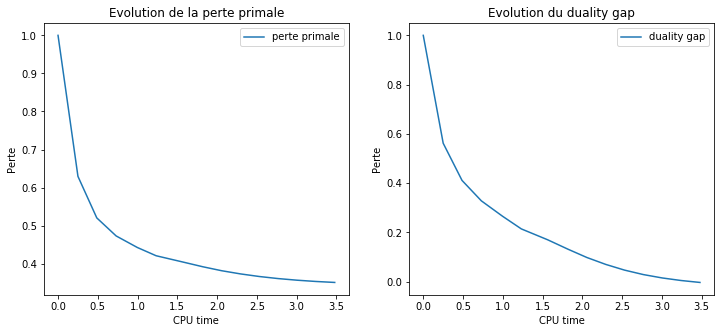

In [59]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps_p), primal_loss_track_p , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps_p), gaps_track_p , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

### Algorithme avec pas décroissant

In [60]:
def SDCA_decreasing_step (X, Y, n_epoch, gamma, T_0_ratio, epsilon, lamb, decreasing_step):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch and decreasing steps

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)
        decreasing_step: indicates whether the step decreases with iterations (boolean)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
    """
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # We record the primal loss
    primal_loss_track = []
    W = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
    
    # We record the dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, Y, lamb))
    
    # We record the duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, Y, lamb)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            if (decreasing_step == True):
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], t**5, lamb, alpha[j], gamma)
            else:
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j], gamma)
            alpha[j] += delta_alpha
            W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record
            # alpha
        Alpha.append(alpha.copy())
            # the primal loss
        primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
            # the dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, Y, lamb)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X, Y, lamb))
            # the duality gap
        gap = duality_gap(np.array(alpha), X, Y, lamb)
        gaps_track.append(gap)
        t += 1

    return(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track)

#### Résultats pour les données simulées

> On sauvegarde les valeurs avec l'indice _d comme decreasing step

In [61]:
n_epoch = 20
gamma = 1.0
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
decreasing_step = True
[Alpha_d, timelaps_d, primal_loss_track_d, dual_loss_track_d, gaps_track_d]=(SDCA_decreasing_step(X_scale,
                                                                                                  Y,
                                                                                                  n_epoch,
                                                                                                  gamma,
                                                                                                  T_0_ratio,
                                                                                                  epsilon, 
                                                                                                  lamb,
                                                                                                  decreasing_step))

On regarde l'évolution de la perte primale et du duality gap

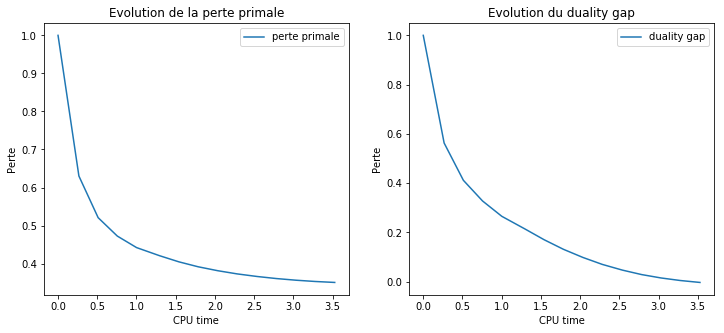

In [62]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps_d), primal_loss_track_d , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps_d), gaps_track_d , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

### Algorithme avec Stochastic Gradient Descent pour la premiere epoch

##### Cas du primal avec hinge loss

On appelle $S$ un ensemble de points, $x_i \in \mathbb{R}^{n}$ et les labels correspondants, $y_i \in \{−1,1\}$. On cherche un hyperplan qui minimiserait la hinge loss totale.

\begin{equation}
w^* = \underset{w}{\text{argmin }} L^{hinge}_S(w) = \underset{w}{\text{argmin }} \sum_i{l_{hinge}(w,x_i,y_i)}= \underset{w}{\text{argmin }} \sum_i{\max{\{0,1-y_iw\cdot x_i}\}}
\end{equation}

On identifie le gradient:

$$\frac{\partial{l_{hinge}}}{\partial w}=
\begin{cases}
  0  & y_iw\cdot x_i \geq 1 \\
  -y_ix & y_iw\cdot x_i < 1
\end{cases}$$

On obtient alors l'update suivant

$$w^{t+1}=\left(1-\frac{1}{t}\right)w^{t} - \frac{1|(y_i w^{t}\cdot x_i)}{\lambda t}x_i$$

##### Cas du dual avec hinge loss

Soit $t \in \{1,...,n\}$


Puisque pour la *Stochastic Gradient Descent*, on update selon une seule observation $t$ à chaque fois, l'objectif est de choisir le réel $\alpha_t$ qui maximise : 
$$ - \frac{1}{n} \phi_t^{\star}(-\alpha_t) - \frac{\lambda}{2} ||w^{t}||^2$$
Or, on a:
$$ \begin{align}
w^{t} = &  w^{t-1} + \Delta w\\
 = & w^{t-1} + \frac{1}{\lambda n}\sum_{i = 1}^{n} \Delta \alpha _{i} x_i\\
 = & w^{t-1} + \frac{1}{\lambda n} \Delta \alpha _{t} x_t \\
 = & w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t \\
\end{align}$$
En effet, $\alpha_t$ est initialisé à 0 et le SGD sert à la première epoch seulement. On se retrouve donc à maximiser:

$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda n}{2} ||w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t ||^2$$

En développant : 
$$ \alpha_t y_t - \frac{\lambda n}{2} \left( ||w^{t-1}||^2 + 2 \frac{\alpha_t}{\lambda n} \langle w^{t-1}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 n^2}||x_t||^2 \right)$$

L'expression est concave du fait du terme de second ordre négatif. L'extremum sera donc un maximum. On applique la formule du maximizer dans un polynome de degré 2:
$$ \alpha_t^{\star}= \frac{\lambda n}{||x_t||^2} \left(y_t - x_t^T w^{t-1}\right)$$


Il faut toutefois éviter d'avoir une dual loss infinie. Il faut donc que $-\alpha_t^{\star}y \in [-1,0] \Leftrightarrow \alpha_t^{\star}y \in [0,1]$

On peut donc adapter l'algorithme pour qu'il incorpore un SGD pour la première epoch.

On commence par ajouter la fonction d'update du SGD

In [63]:
def hinge_sgd_update(y, W, X, t, lamb):    
    """
    Compute alpha update in SGD for first epoch

    Inputs:
        y: label (size 1)
        W: primal weights (n_features)
        X: covariates (n_features)
        t: iteration (size 1)
        lamb: regularization (size 1)

    Outputs:
        update of alpha (size 1)
    """
    alpha_star=((lamb * t) /  (np.linalg.norm(X)**2)) * (y - np.dot(X.T, W))
    if (alpha_star *y <0) and (alpha_star *y >1):
        print("Error SGD")
    return alpha_star

In [66]:
def SDCA_sgd (X, Y, n_epoch, gamma, T_0_ratio, epsilon, lamb, SGD_init):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch and a first epoch using Stochastic 
    Gradient Descent to initialize alpha

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)
        sgd: indicates whether to use SGD for the first epoch (boolean)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
    """
    
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # We record the primal loss
    primal_loss_track = []
    W = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
    
    # We record the dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, Y, lamb))
    
    # We record the duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, Y, lamb)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            # Initialization using SGD if desired
            if (t==0) and (SGD_init==True):
                alpha[i] = hinge_sgd_update(Y[i], W, X[:, i], i, lamb)
                # Due to the evolving dimension of alpha, we compute w manually
                W *= float(i) / float(i + 1)
                W += (1 / (lamb * (i + 1))) * np.array(alpha[i]) * np.array(X[:, i])
                
             # SDCA for the rest
            else:
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j], gamma)
                alpha[j] += delta_alpha
                W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        
        
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record
            # alpha
        Alpha.append(alpha.copy())
            # the primal loss
        primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
            # the dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, Y, lamb)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X,  Y, lamb))
            # the duality gap
        gap = duality_gap(np.array(alpha), X, Y, lamb)
        gaps_track.append(gap)
        t += 1
    # Once it has converged we collect the weights using alpha
        
        # average method
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*len(Alpha)):],axis=0)
    W_bar = w_from_alpha(alpha_bar,X, lamb)
    
        # random method
    k = np.random.randint(int(T_0_ratio*len(Alpha)),len(Alpha)-1)
    alpha_rand = Alpha[k]
    W_rand=w_from_alpha(alpha_rand, X, lamb)
    
    return(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track)

#### Résultats pour les données simulées

> On sauvegarde les valeurs avec l'indice _s comme SGD

In [67]:
n_epoch = 20
gamma = 1.0
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
SGD_init = True

[Alpha_s, timelaps_s, primal_loss_track_s, dual_loss_track_s, gaps_track_s]=(SDCA_sgd(X_scale,
                                                                                      Y,
                                                                                      T,
                                                                                      gamma,
                                                                                      T_0_ratio,
                                                                                      epsilon, 
                                                                                      lamb,
                                                                                      SGD_init))

On regarde l'évolution de la perte primale et du duality gap

In [ ]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps_s), primal_loss_track_s , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps_s), gaps_track_s , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

On regarde l'évolution de la perte primale et du duality gap

### Comparaison des performances des différentes versions

In [68]:
T = 8
gamma = 1.0
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-1
SGD_init = True
decreasing_step = True

[Alpha_p, timelaps_p, primal_loss_track_p, dual_loss_track_p, gaps_track_p]=(SDCA_perm(X_scale,
                                                                                       Y,
                                                                                       n_epoch,
                                                                                       gamma,
                                                                                       T_0_ratio,
                                                                                       epsilon,
                                                                                       lamb))

[Alpha_d, timelaps_d, primal_loss_track_d, dual_loss_track_d, gaps_track_d]=(SDCA_decreasing_step(X_scale,
                                                                                                  Y,
                                                                                                  n_epoch,
                                                                                                  gamma,
                                                                                                  T_0_ratio,
                                                                                                  epsilon, 
                                                                                                  lamb,
                                                                                                  decreasing_step))

[Alpha_s, timelaps_s, primal_loss_track_s, dual_loss_track_s, gaps_track_s]=(SDCA_sgd(X_scale,
                                                                                      Y,
                                                                                      T,
                                                                                      gamma,
                                                                                      T_0_ratio,
                                                                                      epsilon, 
                                                                                      lamb,
                                                                                      SGD_init))

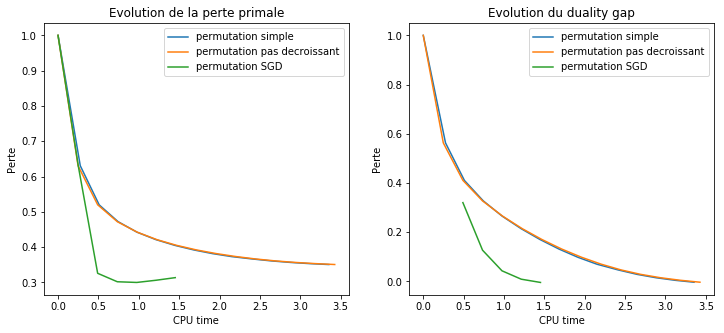

In [69]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps_p), primal_loss_track_p , label="permutation simple")
plt.plot(np.cumsum(timelaps_d), primal_loss_track_d , label="permutation pas decroissant")
plt.plot(np.cumsum(timelaps_s), primal_loss_track_s , label="permutation SGD")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps_p), gaps_track_p, label="permutation simple")
plt.plot(np.cumsum(timelaps_d), gaps_track_d, label="permutation pas decroissant")
plt.plot(np.cumsum(timelaps_s), gaps_track_s, label="permutation SGD")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

## Pegasos algorithm

### Setting first hyperparameters

In [70]:
n_epoch = 5
n_iter = n_epoch*n_samples # for comparison purposes
lamb=0.01

### Basic implementation of Pegasos
We want to show first here the behaviour of the basic implementation of Pegasos as described by Shalev-Shwartz et al. (2007). Additionally, the PEGASOS projection step is skipped, as it
can be shown that even without it, $||w||^2 \leq 4/\lambda$ is maintained.

In [71]:
def pegasos_basic(X,Y,lamb, n_iter):
    """
    Implement Pegasos in its basic definition
    In Shalev-Shwartz, Shai, et al. "Pegasos: Primal estimated sub-gradient solver for svm." 
    Mathematical programming 127.1 (2011): 3-30.
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: labels vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_iter: number of iterations
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    
    """
    m = len(Y) #number of observations
    rtime = [] #keeping track of running time
    
    # Initialisation
    w= np.zeros(n_features) 
    primal_= []


    for i in range(0,n_iter):

        start_time = time.perf_counter()
        
        t=np.random.randint(m) # draw random index
        eta = 1/(lamb*(i+1)) # define step size
        
        # Compute subgradient
        x, y = X[t], Y[t]
        subgrad= y*(w.dot(x))
        
        # Compute weight
        if subgrad <1:
            w=(1-eta*lamb)*w+ (eta*y)*x
        else :
             w=(1-eta*lamb)*w
                
        # Estimate running time
        rtime.append(time.perf_counter() - start_time)
        
        # To monitor the optimization (excluded from rtime)
        cost = cum_loss_primal(w,X,Y,lamb)
        primal_.append(cost)
        
    print("total running time:",sum(rtime), "sec") 
    print("final primal suboptimality:", cost)

    output = namedtuple("output", ["primal", "rtime", "w"])
    out= output(primal_, rtime, w)
    return out
    

In [72]:
result_peg_basic = pegasos_basic(X_scale,Y,lamb,n_iter)

total running time: 0.9293277236865833 sec
final primal suboptimality: 0.159435819761


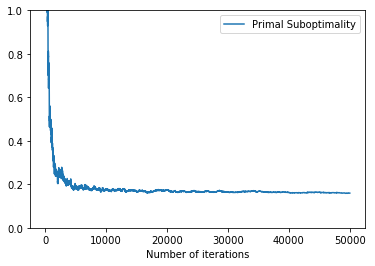

In [73]:
plt.plot(range(0,n_iter),result_peg_basic.primal, label="Primal Suboptimality")
plt.xlabel("Number of iterations")
plt.ylim((0,1))
plt.legend()
plt.show()

### Variant Pegasos
We used a variant of the previous method, with a single example used in each update: Following
Bottou (Web Page), instead of sampling an example independently
at each iteration, a random permutation over the training set
is used. When the permutation is exhausted, a new, independent,
random permutation is drawn. Although this variation does not
match the theoretical analysis, it performs slightly better in practice, as in Shalev-Shwartz, Shai, and Nathan Srebro. "SVM optimization: inverse dependence on training set size." Proceedings of the 25th international conference on Machine learning. ACM, 2008.

**The idea**: performs the subgradient descent over all data points per pass. With this systematic method we avoid bias coming from neglecting a random portion of our dataset.

**Impact on implementation**: we now think in terms of epoch rather than number of iterations


In [31]:
def pegasos_mod(X,Y,lamb, n_epoch): 
    """
    Implement Pegasos in its variant definition
    cf. Bottou.
    Idea: define with regard to pass on the data
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: labels vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_epoch: number of epoch
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    """
    
    m = len(Y) #number of observations

    primal_= []
    rtime = []
    
    w= np.zeros(n_features) 
    

    
    for i in range(0, n_epoch):
        
        start_time = time.perf_counter() 
        
        # Shuffle datasets
        p= np.random.permutation(m)
        Xs=X[p]
        Ys=Y[p]
        
        # Subgradient descent over all data points
        for t in range(0,m):
            eta = 1/(lamb*(t+1))
            x, y= Xs[t], Ys[t]
            subgrad= y*(w.dot(x))
            if subgrad <1:
                w=(1-eta*lamb)*w+ (eta*y)*x
            else:
                w=(1-eta*lamb)*w
                    
        # Monitor convergence            
        rtime.append(time.perf_counter() - start_time)
        cost = cum_loss_primal(w,X,Y, lamb)
        primal_.append(cost)

        
        
    print("running time:",sum(rtime)) 

    print("final primal suboptimality:", cost)

    output = namedtuple("output", ["primal", "rtime", "w"])
    out= output(primal_, rtime, w)
    return out

In [32]:
result_peg_mod = pegasos_mod(X_scale,Y, lamb, n_epoch)

running time: 0.305596494814381
final primal suboptimality: 0.171040580479


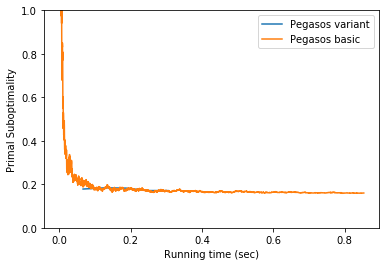

In [33]:
plt.plot(np.cumsum(result_peg_mod.rtime),result_peg_mod.primal, label="Pegasos variant")
plt.plot(np.cumsum(result_peg_basic.rtime),result_peg_basic.primal, label="Pegasos basic")
plt.xlabel("Running time (sec)")
plt.ylabel("Primal Suboptimality")
plt.ylim((0,1))
plt.legend()
plt.show()

#### Running time per iteration
To check if running time is constant across iteration as said in the article

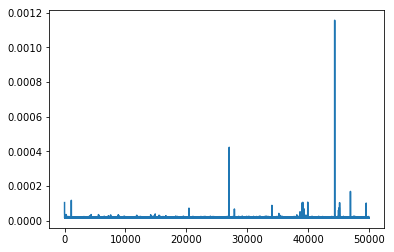

In [34]:
plt.plot(result_peg_basic.rtime) 
plt.show()

### Other variants

Other implementations could have been followed. 

- A *mini-batch* version has been provided in the article. It has been shown that in practice no improvement is to see neither on running time nore in global performance. The only interesting aspect of this implementation is of course for parallelisation purposes but since we didn't plan to adapt our algorithm to this setting, we prefered not to follow this path.
- A *kernelized* version exists for non linear SVM, with Mercier kernels. We prefer for comparison purpose and to handle the basic version to focus on linear SVM.
- Include an *unregularized bias* in the loss which plays a role in unbalanced dataset: according to the authors, including an unregularized bias term does not significantly change the predictive performance for any of their data sets used. Furthermore, SDCA does not incorporate a bias term either. Nonetheless, there are clearly learning problems in specific setting (text processing for example).

## 2. Experimental comparison

### Setting the framework

A key feature of algorithm implementation that we, for now, avoid to deal with is the **stopping criterion**. Indeed we know to set a common framework for performance comparison purposes. Nevertheless, if in the SDCA definition is included a stopping rule -namely a duality gap lower than a given threshold-, the Pegasos is not conceived with an intrinsec stopping rule.

After several experiments and readings (especially a conference by Bottou -http://leon.bottou.org/slides/largescale/lstut.pdf), we came with the following setting.

**Process**: Since we want to assess the performance both on the *running time* and on the *accuracy* of the final prediction, we create a split between a training set and a validation set over which to monitor the convergence. Why ? Because since we want to be able to generalize out of the sample our results, we think that even in the optimisation process, the metric should be estimated on a blind dataset.

**Metric**: Several metrics could be used, but because of the spirit of the algorithm we've chosen to focus on the primal suboptimality as in Shalev-Shwartz et al. (2007) on the validation set.

**Stopping criteria**: As explained in Bottou, we should stop the gradient descent when the cost function stops descreasing. For evaluating this phenomenon, we set the difference between the primal function previous and current epoch to be smaller than a given threshold. After several experiments, 0.0001 seems to be a good value, but it remains as hyperparameters in our function in case of.

**Final goodness-of-fit evaluation**: Moreover to push a little further in this direction, we split before any computation, the original dataset in two, a training one and a test one, so that after all optimisation of both algorithm their performances are computed on a totally new dataset.

**In practice**: We split the original dataset in a training (80%) and a test (20%) set. Then each algorithm has for first step a partitioning of the train set in a training (80%) set and a validation (20%) set, such that the stopping criteria is computed over the validation set. In the end our dataset kept for estimation entails circa two thirds of the original one.

In [35]:
test_ratio = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state = 0)

In [46]:
def pegasos(X,Y,lamb, test_ratio=test_ratio, stop_thresh=0.0001 ): 
    
    """
    Implement Pegasos in its variant definition 
    with stopping criterion on primal function estimated on a test dataset
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: labels vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_epoch: number of epoch
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    """
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, shuffle=True, 
                                                        random_state = 0)
    m = len(Y_train) #number of observations
    
    #Initialisation
    primal_val= []
    rtime = []
    w= np.zeros(n_features) 
    i=0
    diff =50 #random number greater than stop_thresh
    
    while (abs(diff) > stop_thresh):
        
        start_time = time.perf_counter()
        
        # Shuffle datasets
        p= np.random.permutation(m)
        Xs=X_train[p]
        Ys=Y_train[p]
        
        # Estimation step
        for t in range(0,m):
            eta = 1/(lamb*(t+1))
            x, y= Xs[t], Ys[t]
            subgrad= y*(w.dot(x))
            if subgrad <1:
                w=(1-eta*lamb)*w+ (eta*y)*x
            else:
                w=(1-eta*lamb)*w
                    
        # Validation step
        cost_val = cum_loss_primal(w,X_val,Y_val, lamb)
        primal_val.append(cost_val)
        
        if i>2:
            diff = primal_val[i] - primal_val[i-1]
        
        i+=1
        rtime.append(time.perf_counter() - start_time)

    print("total number of epoch:",i) 
    print("running time:",sum(rtime), "sec") 

    print("After optimisation")
    print("Primal on validation", cost_val)
    output = namedtuple("output", ["primal_val","rtime", "w"])
    out= output(primal_val, rtime, w)
    return out

In [37]:
result_peg = pegasos(X_train, Y_train, lamb
                     #,stop_thresh=0.01
                    )

total number of epoch: 67
running time: 2.652404898777604 sec
After optimisation
Primal on validation 0.197982067086


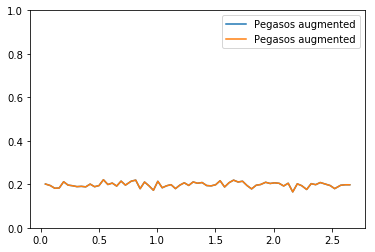

In [39]:
plt.plot(np.cumsum(result_peg.rtime),result_peg.primal_val, label = "Pegasos augmented")
plt.ylim((0,1))
plt.legend()
plt.show()


## SDCA

We perform the same thing on our SDCA algorithm using a SGD initilization for the first epoch.

In [75]:
def SDCA (X, Y, n_epoch, gamma, T_0_ratio, epsilon, lamb, SGD_init):
    """
    SDCA Algorithm with a permutation of observations
    at each epoch and a first epoch using Stochastic 
    Gradient Descent to initialize alpha and
    stopping criterion on primal function estimated on a test dataset

    Inputs:
        X: covariates matrix (n_samples*n_features)
        Y: labels vector (n_samples)
        lamb: regularization (size 1)
        n_epoch: number of epochs (size 1)
        T_0_ratio: fraction indicating the share of iterations that we keep
                    to compute the final alpha and w (size 1)
        epsilon: duality gap threshold ending to exit the loop (size 1)
        lamb: regularization (size 1)
        sgd: indicates whether to use SGD for the first epoch (boolean)

    Outputs:
        Alpha: matrix of weights (each row corresponds to an epoch)
        timelaps: vector of computational times (each element an epoch)
        primal_loss_track: vector of primal losses (each element an epoch)
        dual_loss_track: vector of dual losses (each element an epoch)
        gaps_track : vector of duality gaps (each element an epoch)
        W_bar: final weights, estimated by average method (n_features)
        W_rand: final weights, estimated by random method (n_features)
    """
    
    # To be closer to the article, we use the transpose of X in our computations
    X=X.T
    
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # We record the primal loss
    primal_loss_track = []
    W = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
    
    # We record the dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, Y, lamb))
    
    # We record the duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, Y, lamb)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < n_epoch) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            # Initialization using SGD if desired
            if (t==0) and (SGD_init==True):
                alpha[i] = hinge_sgd_update(Y[i], W, X[:, i], i, lamb)
                # Due to the evolving dimension of alpha, we compute w manually
                W *= float(i) / float(i + 1)
                W += (1 / (lamb * (i + 1))) * np.array(alpha[i]) * np.array(X[:, i])
                
             # SDCA for the rest
            else:
                delta_alpha = hinge_sdca_update(Y[j], W, X[:,j], n_samples, lamb, alpha[j], gamma)
                alpha[j] += delta_alpha
                W += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        
        
        end = time.perf_counter()
        timelaps.append(end - start)
        # After each epoch we record
            # alpha
        Alpha.append(alpha.copy())
            # the primal loss
        primal_loss_track.append(cum_loss_primal(W, X.T, Y, lamb))
            # the dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, Y, lamb)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X,  Y, lamb))
            # the duality gap
        gap = duality_gap(np.array(alpha), X, Y, lamb)
        gaps_track.append(gap)
        t += 1
    # Once it has converged we collect the weights using alpha
        
        # average method
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*len(Alpha)):],axis=0)
    W_bar = w_from_alpha(alpha_bar,X, lamb)
    
        # random method
    k = np.random.randint(int(T_0_ratio*len(Alpha)),len(Alpha)-1)
    alpha_rand = Alpha[k]
    W_rand=w_from_alpha(alpha_rand, X, lamb)
    

    output = namedtuple("output", (["Alpha","timelaps", "primal_loss_track", 
                                    "dual_loss_track","gaps_track", "W_bar","W_rand"]))
    out= output(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, W_bar, W_rand)
    return out

In [76]:
T = 8
gamma = 1.0
T_0_ratio = 1/2
stop_thresh =1e-7 
lamb = 1e-1
SGD_init = True
result_sdca = SDCA(X_train, Y_train, T, gamma, T_0_ratio, stop_thresh, lamb, SGD_init)

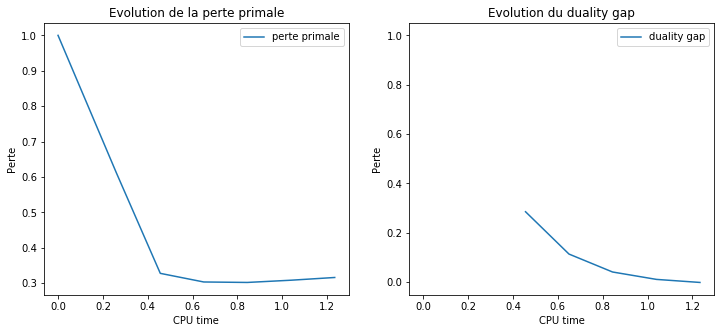

In [77]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(result_sdca.timelaps), result_sdca.primal_loss_track , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(result_sdca.timelaps), result_sdca.gaps_track , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

## Assessing goodness-of-fit
We now use the untouched test dataset to compare traditionnal classification metric between our two algorithms.

In [45]:
y_pred_peg = np.sign(X_test.dot(result_peg.w))

In [41]:
print("f1 Pegasos",f1_score(Y_test, y_pred_peg))

f1 Pegasos 0.938159879336


In [42]:
confusion_matrix(Y_test, y_pred_peg)

array([[944,  64],
       [ 59, 933]])

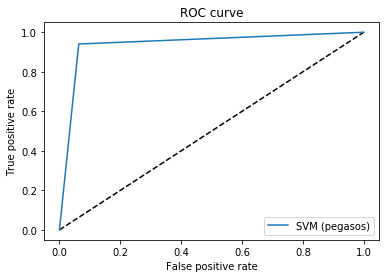

In [43]:
fpr, tpr, _ =metrics.roc_curve(Y_test, y_pred_peg)
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM (pegasos)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()